### [Optimizing a Rate of Change Trading Strategy with Bayesian Methods](https://wire.insiderfinance.io/optimizing-a-rate-of-change-trading-strategy-with-bayesian-methods-a83117fc061c)

> A practical walkthrough of combining technical indicators and machine learning to refine trading decisions



The **_Rate of Change (ROC)_** is a momentum oscillator that measures the percentage change in price over a given number of periods. It helps identify when momentum is accelerating or decelerating:

- **High Positive ROC** suggests strong upward momentum.
- **Negative ROC** can signal weakness or a potential reversal.

The trading logic will be:

- **Buy** when the ROC rises above a positive threshold.
- **Sell** when the ROC falls below a negative threshold.

In [1]:
!pip install -q yfinance bayesian-optimization ta tabulate

  Preparing metadata (setup.py) ... done


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from ta.momentum import ROCIndicator
from bayes_opt import BayesianOptimization
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Tesla stock data
symbol = 'TSLA'
initial_cash = 1  # Initial cash for backtesting
data = yf.download(symbol, start='2020-01-01', end='2024-12-31')
data.columns = data.columns.get_level_values(0)
data = data[['Close']]

data.dropna(inplace=True)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-02,28.684000
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334


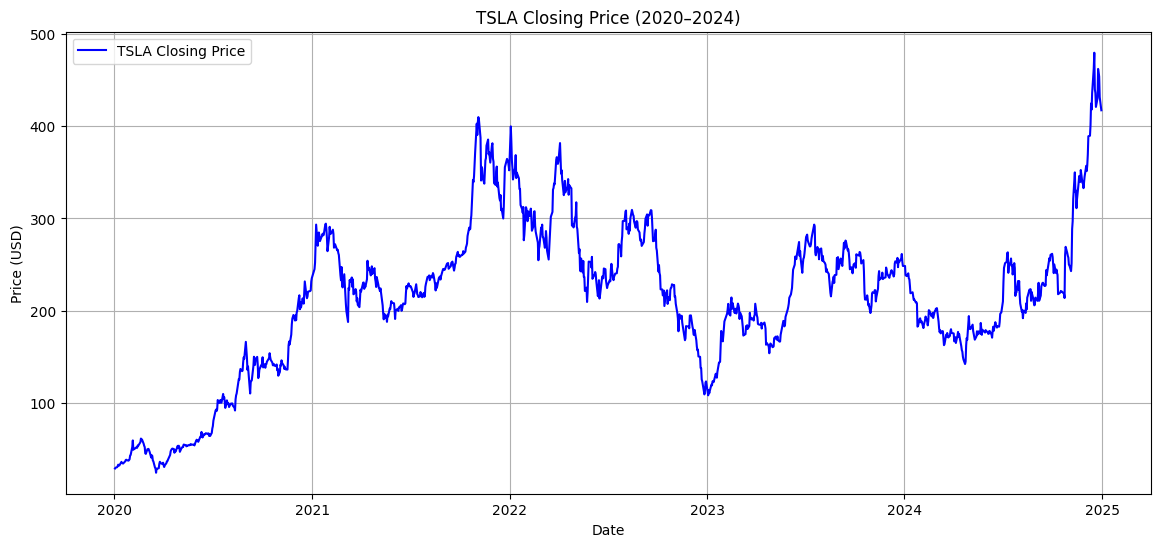

In [4]:
# Visualize the closing price of the stock
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label=f'{symbol} Closing Price', color='blue')
plt.title(f'{symbol} Closing Price (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.savefig('closing_price.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Train-test split (70% train, 30% test)
train_size = int(len(data) * 0.7)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

print(f"Training from {train_data.index[0]} to {train_data.index[-1]}")
print(f"Testing from {test_data.index[0]} to {test_data.index[-1]}")

Training from 2020-01-02 00:00:00 to 2023-06-29 00:00:00
Testing from 2023-06-30 00:00:00 to 2024-12-30 00:00:00


In [6]:
def backtest_strategy(df, roc_window, buy_threshold, sell_threshold):
    df = df.copy()
    roc_window = int(roc_window)
    buy_threshold = float(buy_threshold)
    sell_threshold = float(sell_threshold)

    roc = ROCIndicator(close=df['Close'], window=roc_window)
    df['ROC'] = roc.roc()

    position = 0
    cash = initial_cash
    portfolio = []
    trades = 0
    buy_signals = []
    sell_signals = []

    for i in range(roc_window, len(df)):
        if df['ROC'].iloc[i] > buy_threshold and position == 0:
            position = cash / df['Close'].iloc[i]
            cash = 0
            buy_signals.append((df.index[i], df['Close'].iloc[i]))
            trades += 1
        elif df['ROC'].iloc[i] < sell_threshold and position > 0:
            cash = position * df['Close'].iloc[i]
            position = 0
            sell_signals.append((df.index[i], df['Close'].iloc[i]))
            trades += 1

        portfolio_value = cash + (position * df['Close'].iloc[i])
        portfolio.append(portfolio_value)

    final_value = cash + position * df['Close'].iloc[-1]
    return_percentage = (final_value - initial_cash) / initial_cash * 100

    return return_percentage, trades, buy_signals, sell_signals, portfolio

In [7]:
def objective(roc_window, buy_threshold, sell_threshold):
    returns, _, _, _, _ = backtest_strategy(train_data, roc_window, buy_threshold, sell_threshold)
    return returns

In [8]:
pbounds = {
    'roc_window': (3, 30),
    'buy_threshold': (0.1, 10),
    'sell_threshold': (-10, -0.1)
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=20)
best_params = optimizer.max['params']

|   iter    |  target   | roc_wi... | buy_th... | sell_t... |
-------------------------------------------------------------
| 1         | 1377.2376 | 13.112583 | 9.5120716 | -2.753259 |
| 2         | 659.94675 | 19.163779 | 1.6445845 | -8.455654 |
| 3         | 355.19602 | 4.5682575 | 8.6751438 | -4.048961 |
| 4         | 457.29206 | 22.117959 | 0.3037864 | -0.397892 |
| 5         | 428.38426 | 25.475951 | 2.2021571 | -8.199932 |
| 6         | 768.01749 | 19.520028 | 1.8527286 | -6.756215 |
| 7         | 1797.6413 | 15.647600 | 8.4995396 | -3.470997 |
| 8         | 1456.5780 | 18.801638 | 10.0      | -1.335548 |
| 9         | 1027.3603 | 17.091393 | 10.0      | -7.337967 |
| 10        | 1125.8429 | 15.633181 | 5.9878993 | -0.904106 |
| 11        | 1367.2082 | 14.247063 | 6.4457534 | -5.391146 |
| 12        | 1048.3791 | 18.249631 | 7.5753015 | -3.891982 |
| 13        | 1189.5702 | 15.874287 | 10.0      | -1.523066 |
| 14        | 947.56086 | 14.621363 | 9.3747821 | -4.900470 |
| 15    

In [9]:
best_params

{'roc_window': np.float64(16.349050889932972),
 'buy_threshold': np.float64(7.716463052925842),
 'sell_threshold': np.float64(-2.561394163704084)}

In [10]:
best_roc = int(best_params['roc_window'])
best_buy = float(best_params['buy_threshold'])
best_sell = float(best_params['sell_threshold'])

returns, trades, buy_signals, sell_signals, portfolio = backtest_strategy(
    test_data, best_roc, best_buy, best_sell
)

print(f"Final Return on Test Set: {returns:.2f}%")
print(f"Number of Trades: {trades}")

Final Return on Test Set: 46.51%
Number of Trades: 15


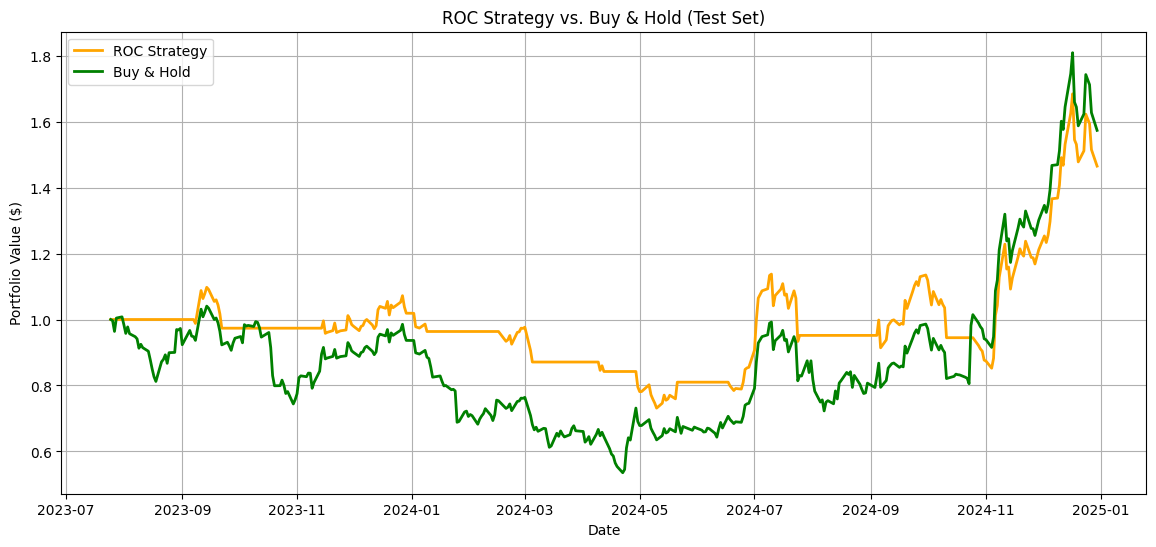

In [11]:
# Visualize portfolio value vs. buy-and-hold on the test set
df = test_data.copy()
df = df.iloc[best_roc:].copy()  # Skip rows lost due to ROC calculation

# Strategy Portfolio Value
df['Strategy'] = portfolio

# Buy-and-hold simulation
initial_price = df['Close'].iloc[0]
df['BuyHold'] = (df['Close'] / initial_price) * initial_cash

# Plot both
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Strategy'], label='ROC Strategy', color='orange', linewidth=2)
plt.plot(df.index, df['BuyHold'], label='Buy & Hold', color='green', linewidth=2)

plt.title('ROC Strategy vs. Buy & Hold (Test Set)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.savefig('portfolio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

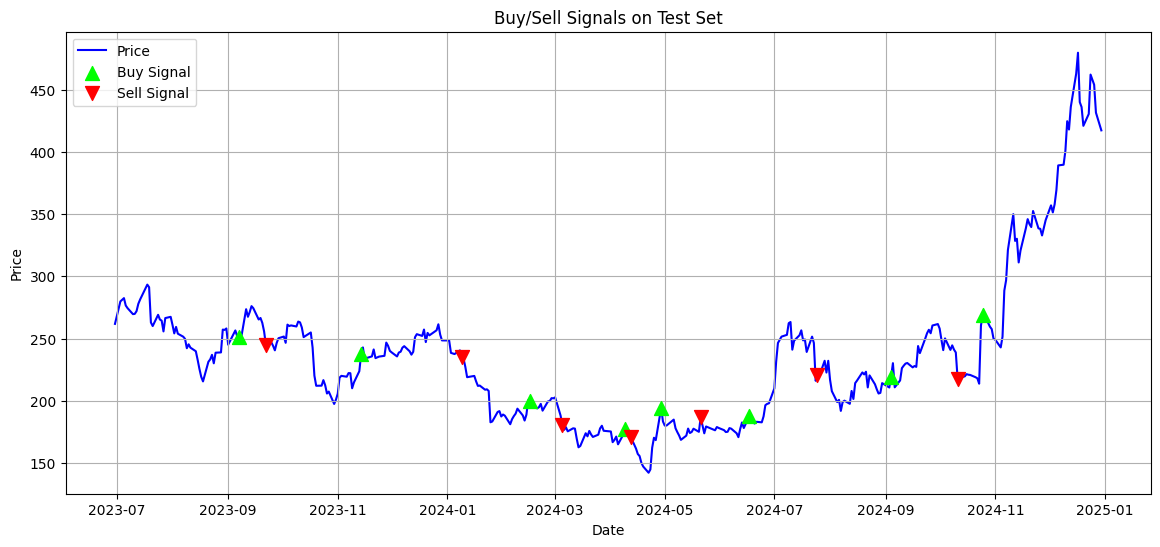

In [12]:
# Plot buy/sell signals on test set
plt.figure(figsize=(14,6))

# Plot the closing price first
plt.plot(test_data.index, test_data['Close'], label='Price', color='blue', zorder=1)

# Plot buy signals
for buy in buy_signals:
    plt.scatter(buy[0], buy[1], marker='^', color='lime', s=100, label='Buy Signal', zorder=2)

# Plot sell signals
for sell in sell_signals:
    plt.scatter(sell[0], sell[1], marker='v', color='red', s=100, label='Sell Signal', zorder=2)

# Only show each label once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Buy/Sell Signals on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('buy_sell_signals.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Strategy evaluation
total_trades = len(buy_signals) + len(sell_signals)

if len(buy_signals) == len(sell_signals):
    successful_trades = sum(
        sell[1] > buy[1] for buy, sell in zip(buy_signals, sell_signals)
    )
    win_rate = f"{(successful_trades / len(sell_signals) * 100):.2f}%"
else:
    win_rate = 'Inconsistent buy/sell pairs'

test_df = test_data.copy().iloc[best_roc:].copy()  # align with portfolio calculation start
initial_price = test_df['Close'].iloc[0]
final_price = test_df['Close'].iloc[-1]

final_strategy_value = portfolio[-1]
final_bh_value = (final_price / initial_price) * initial_cash
bh_return_pct = (final_bh_value - initial_cash) / initial_cash * 100
strategy_return_pct = (final_strategy_value - initial_cash) / initial_cash * 100

summary = [
    ["Initial Cash", f"${initial_cash}", f"${initial_cash}"],
    ["Final Portfolio Value", f"${final_strategy_value:.2f}", f"${final_bh_value:.2f}"],
    ["Total Return (%)", f"{strategy_return_pct:.2f}%", f"{bh_return_pct:.2f}%"],
    ["Total Trades Executed", total_trades, "N/A"],
    ["Buy Trades", len(buy_signals), "N/A"],
    ["Sell Trades", len(sell_signals), "N/A"],
    ["Win Rate", win_rate, "N/A"]
]

print(tabulate(summary, headers=["Metric", "ROC Strategy", "Buy & Hold"], tablefmt="rounded_grid"))

╭───────────────────────┬─────────────────────────────┬──────────────╮
│ Metric                │ ROC Strategy                │ Buy & Hold   │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Initial Cash          │ $1                          │ $1           │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Final Portfolio Value │ $1.47                       │ $1.57        │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Total Return (%)      │ 46.51%                      │ 57.35%       │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Total Trades Executed │ 15                          │ N/A          │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Buy Trades            │ 8                           │ N/A          │
├───────────────────────┼─────────────────────────────┼──────────────┤
│ Sell Trades           │ 7                           │ N/A          │
├─────